# Job Application Analysis

I used this resource for much of the concepts and similar analysis: <br>
https://github.com/conordewey3/Job-Rejection-Analysis

Some background information on this data set:
* I was an undergraduate student at Rutgers University and majored in Business Analytics and Supply Chain Management
* The hiring process took place during my senior year of college, starting in June of 2018 until ~December-January
* Role: I was mainly targeting rotational programs starting summer of 2019 that bring in college hires and rotate them through various departments, offer training on leadership, etc.
* Industry: was mainly seeking a healthcare industry in information technology or data analytics, secondary choice was a supply chain program
* I had three internship/co-op experiences on my resume prior to applying to these jobs (two in a supply chain role and one in an IT role) and a few extracurriculars
* The process of interviewing was incredibly difficult and competitive, and I feel grateful to have gotten a job right out of college. The amount of effort I put into job searching last year inspired me to create this analysis. 

Preliminary Assumptions:
* I believe that I interviewed around 40 times (could be phone, video, in person, multiple rounds), and want to try to find out the true number

In [1]:
import pandas as pd
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import re
import nltk
#import ssl

#try:
#    _create_unverified_https_context = ssl._create_unverified_context
#except AttributeError:
#    pass
#else:
#    ssl._create_default_https_context = _create_unverified_https_context
#nltk.download('all')
from nltk.corpus import stopwords
from collections import Counter
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.3)

## **1) Load the CSV and clean the data set**
<br>

* I added additional columns **Company**, **Sector**, and **Industry**. I manually added the companies by checking the Sender and Subject columns, and then added a VLOOKUP from a Forbes Top 2000 Companies list to grab the sector and industry.

In [3]:
# Read data
emails = pd.read_csv('combined_csv.csv')
#emails.head()

# Convert date to datetime format
emails['Date'] = pd.to_datetime(emails.Date)
#emails.dtypes

# Excluding Sender info
for_show = emails.drop(columns="Sender")
for_show.head()

,Date,Time,Day,Hour,Subject,Text,Company,Sector,Industry
0,2018-06-19 22:50:00,22:50:41,Tues,22,Novo Nordisk Early Talent Community,Thank you for submitting your resume,Novo Nordisk,Health Care,Pharmaceuticals
1,2018-06-20 16:16:00,16:16:28,Weds,16,Application Status Update For R13607 - 2018 In...,[<email.message.Message object at 0x119fce7f0>...,Sanofi,Health Care,Pharmaceuticals
2,2018-07-10 21:16:00,21:16:22,Tues,21,2019 IT Emerging Talent Rotational (ETR) Progr...,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01//...",Merck,Health Care,Pharmaceuticals
3,2018-07-10 21:43:00,21:43:06,Tues,21,Thank you for applying!,[<email.message.Message object at 0x119fceeb8>...,Vanguard,Financials,Investment Services
4,2018-07-16 20:15:00,20:15:32,Mon,20,John Hancock: Your application for 2019 Busine...,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01//...",Manulife,Consumer Discretionary,Life & Health Insurance


In [4]:
# Dataset Info
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 10 columns):
Date        892 non-null datetime64[ns]
Time        892 non-null object
Day         892 non-null object
Hour        892 non-null int64
Sender      892 non-null object
Subject     892 non-null object
Text        892 non-null object
Company     892 non-null object
Sector      862 non-null object
Industry    862 non-null object
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 69.8+ KB


In [5]:
# Filter Out Reply Emails

# sender comes in format ('Firstname Lastname', 'email@email.com')
# remove the parenthesis, commas and quotation marks from Sender
emails['Sender'] = emails['Sender'].str.replace("(","")
emails['Sender'] = emails['Sender'].str.replace(")","")
emails['Sender'] = emails['Sender'].str.replace(",","")
emails['Sender'] = emails['Sender'].str.replace("'","")
#print(emails['Sender'].head())

# remove my replies
exclude_reply_mail = emails[~emails['Sender'].isin(['LAUREN REDEKER ler111@scarletmail.rutgers.edu','Lauren Redeker lredeker25@gmail.com'])]
#print(exclude_reply_mail.head())
print("Total Emails:", len(emails))
#print("Total Emails Without My Replies:", len(exclude_reply_mail))

# remove any emails with Re in Subject Line
exclude_all_replies = exclude_reply_mail[~exclude_reply_mail['Subject'].str.contains("RE: | Re: ")]
print("Total Emails Without My Replies:", len(exclude_all_replies))

Total Emails: 892
Total Emails Without My Replies: 684


## 2) Now let's do some ~ eda ~ 
<br>

* I was mainly curious to learn how many companies / jobs I actually applied to, how many interviews I went on, etc.

In [6]:
# Companies I applied to

#make into a list
companylist = emails['Company'].tolist()
#convert list to set
companylist = set(companylist)
#print(companylist)
print("I applied to", len(companylist), "companies.")
print("I got 4 offers.")

I applied to 172 companies.
I got 4 offers.


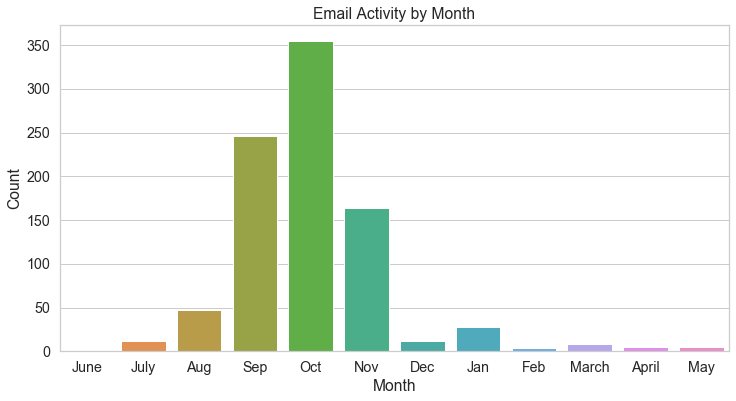

In [7]:
#  Email Activity by Month

# Create a month column
Month = emails['Date'].astype(str).str[:7]
emails['Month'] = Month

# take the first 2 values of the Date column, map it to the proper month
month_dict = {'2018-06': 'June', '2018-07': 'July', '2018-08': 'Aug', '2018-09': 'Sep', '2018-10': 'Oct', '2018-11': 'Nov',
               '2018-12': 'Dec', '2019-01': 'Jan', '2019-02': 'Feb', '2019-03':'March', '2019-04':'April', '2019-05': 'May'}
emails["Month"] = emails["Month"].map(month_dict)

# Plot of emails by month
plt.figure(figsize=(12,6))
sns.countplot(emails['Month']).set_title("Email Activity by Month");
plt.xlabel('Month')
plt.ylabel('Count');
plt.show()

October was a busy month! Many companies recruit University students in the Fall (~ 9 months to a year before the start date), and responses started rolling around in the winter months; it's best to apply early!

In [8]:
# Subject list
exclude_all_replies['Subject'].value_counts()

You have a new notification on Handshake                                                                                        30
Thank you for applying!                                                                                                         10
Your application has been reviewed                                                                                               9
Thank you for your interest                                                                                                      7
McKinsey & Company                                                                                                               5
                                                                                                                                ..
NOTIFICATION: Position Status - RIS0005G-2019 Prudential Risk\r\n Management Development Program (RMDP), Full-time Associate     1
Your application to Bayer U.S. LLC was successfully submitted                      

I applied to most jobs through Handshake, a University job search portal, and so I recieved many automated responses letting me know that my application was submitted.

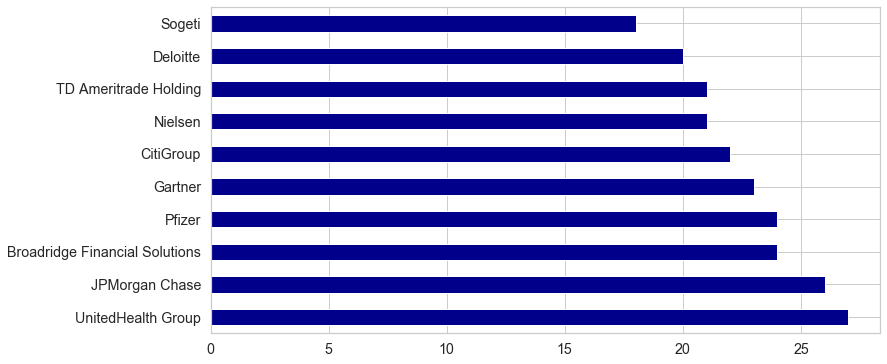

In [9]:
# Heaviest Email Interaction

emails = emails[emails.Company != 'Unidentifiable']
emails['Company'].value_counts()[:10].plot(kind='barh',figsize=(12, 6), color="darkblue")
# least interctions add .sort_values() after value_counts

This makes sense since I had multiple rounds of interviews with most of these companies. 

In [10]:
# Timespan of communication with top 10

#drop_col = exclude_all_replies.drop(columns=["Time","Day","Subject","Hour","Sender","Text","Sector","Industry"])
pick_comp = exclude_all_replies[exclude_all_replies['Company'].isin(['Sogeti','Deloitte','TD Ameritrade Holding','Nielsen','CitiGroup','Gartner','Broadridge Financial Solutions','Pfizer','JPMorgan Chase','UnitedHealth Group'])]

#min_date = pick_comp.groupby(['Company'])['Date'].min()
#max_date = pick_comp.groupby(['Company'])['Date'].max()

pick_comp.groupby('Company')['Date'].max()- pick_comp.groupby('Company')['Date'].min()

Company
Broadridge Financial Solutions    97 days 18:08:00
CitiGroup                         91 days 01:08:00
Deloitte                          33 days 02:26:00
Gartner                           34 days 07:20:00
JPMorgan Chase                   157 days 11:10:00
Nielsen                          323 days 23:35:00
Pfizer                           109 days 23:15:00
Sogeti                            40 days 01:01:00
TD Ameritrade Holding             39 days 14:40:00
UnitedHealth Group                85 days 22:32:00
Name: Date, dtype: timedelta64[ns]

This may be misleading because<br>
* I applied to more than one role for some of these companies
* Some never provided a rejection letter (i.e. Gartner)
* I withdrew from some of these myself
<br>

Regardless, I think it's insightful to say the process can take somewhere between 1-3 months. Deloitte was the fastest (said hey come interview tomorrow and then we let you know that night), and JPMorgan Chase was the slowest (initial phone interview took really long time to hear back from, and same with second interview). Nielsen was probably the worst with their response times, as I didn't get any interview with them and all of their messages were automated

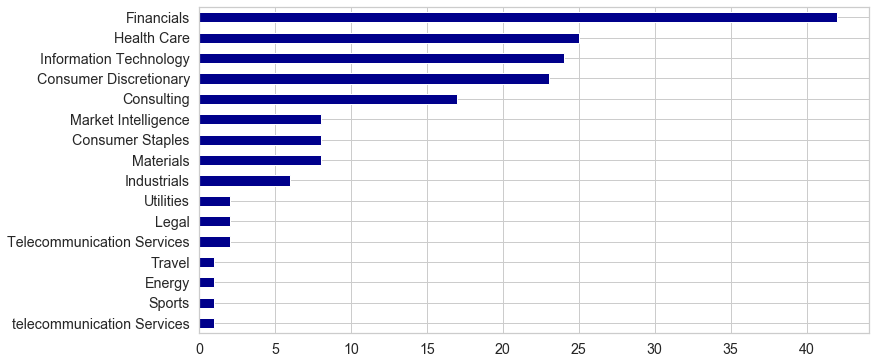

In [11]:
# Applications by Sector

# take just the Company and Sector columns
sector = emails[['Company','Sector']]
#print(sector)

# take out the duplicates of company
sector_drop_dup = sector.drop_duplicates(['Company'])
#print(sector_drop_dup)

# plot it
pd.value_counts(sector_drop_dup['Sector']).sort_values().plot(kind='barh',figsize=(12, 6), color="darkblue")

Although my top choice was healthcare, I also applied for a lot of financial services companies. The companies I applied to were heavily influenced by the openings that came through the University portal and if the positions aligned with what I was looking for. Major banks, pharmaceutical firms and consulting firms heavily recruited at my University.

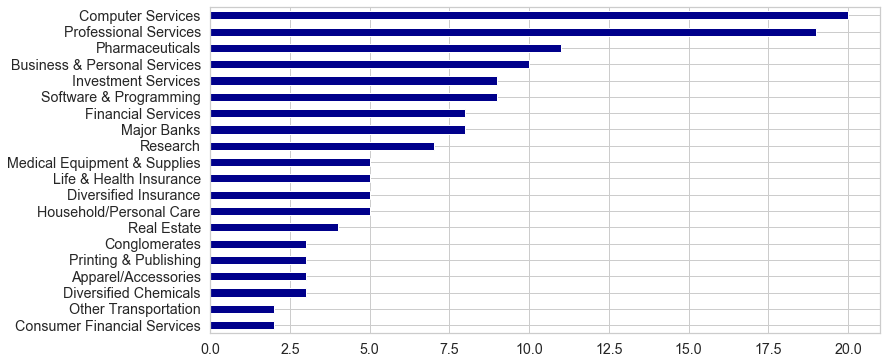

In [12]:
### Applications by Industry (Top 20) ###

# take just the Company and Industry columns
industry = emails[['Company','Industry']]
#print(industry.head())

# take out the duplicates of company
industry_drop_dup = industry.drop_duplicates(['Company'])
#print(industry_drop_dup.head())

#plot it
pd.value_counts(industry_drop_dup['Industry'])[:20].sort_values().plot(kind='barh',figsize=(12, 6), color="darkblue")

In [14]:
# Search for Companies that didn't respond to my initial application

# making an assumption that any company with only one row didn't get back to me, and so filtering for only Compay names that show up once
filter = exclude_all_replies[['Date','Subject','Text','Company']][exclude_all_replies['Company'].isin(exclude_all_replies['Company'].value_counts()[exclude_all_replies['Company'].value_counts()<2].index)]
#filter = pd.DataFrame(data=filter)

# filter out companies I may have not responded to
#add month column back
Month = filter['Date'].astype(str).str[:7]
filter['Month'] = Month
filter["Month"] = filter["Month"].map(month_dict)
filter = filter[filter['Month'].isin(['June','July','Aug','Sep','Oct'])]
filter

,Date,Subject,Text,Company,Month
0,2018-06-19 22:50:00,Novo Nordisk Early Talent Community,Thank you for submitting your resume,Novo Nordisk,June
1,2018-06-20 16:16:00,Application Status Update For R13607 - 2018 In...,[<email.message.Message object at 0x119fce7f0>...,Sanofi,June
4,2018-07-16 20:15:00,John Hancock: Your application for 2019 Busine...,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01//...",Manulife,July
9,2018-07-25 10:17:00,Your resume,Hi Lauren\r\nRecently I came across your resum...,Campbell Soup,July
10,2018-07-26 16:40:00,Aflac Career Opportunity Awaits!,"Good morning Lauren,\r\n\r\n\r\nWith everyone ...",Aflac,July
11,2018-08-05 13:03:00,Your candidate reference number - Thank you fo...,PGh0bWw+PGhlYWQ+PE1FVEEgaHR0cC1lcXVpdj0iQ29udG...,General Electric,Aug
19,2018-08-27 09:49:00,Technology Leadership Program-1811126 at BNY M...,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01//...",Bank of New York Mellon,Aug
75,2018-09-18 16:12:00,Thank you for applying to WeWork,[<email.message.Message object at 0x119fe79e8>...,WeWork,Sep
99,2018-09-26 16:02:00,Thank You For Applying!,[<email.message.Message object at 0x119ff6860>...,Dun & Bradstreet,Sep
106,2018-09-26 18:15:00,Thank you for submitting your job application,Jobs [1]=C2=A0=C2=A0|=C2=A0=C2=A0Recruiting [2...,Michael Page,Sep


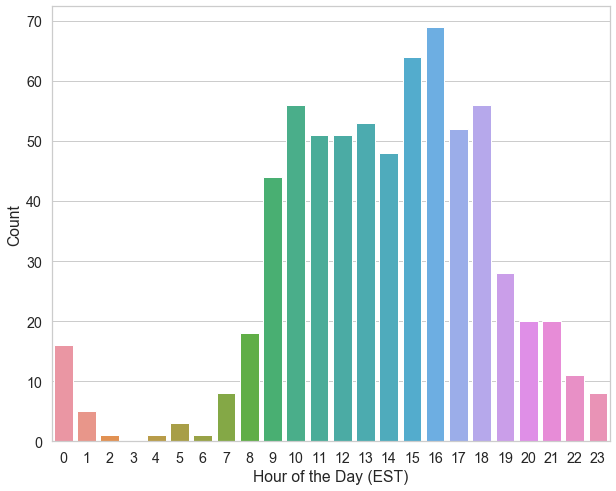

In [15]:
### Responses by hour of day ###
plt.figure(figsize=(10,8))
sns.countplot(exclude_all_replies['Hour'], order=np.arange(0,24));
plt.xlabel('Hour of the Day (EST)')
plt.ylabel('Count');

In [142]:
# Who are the late ones

# Subset data
late = exclude_all_replies[exclude_all_replies['Hour'].isin(['22','23','0','1','2'])]
late = late.replace(0,24)
late = late.replace(1,25)
late = late.replace(2,26)

# take company
sect_late = late[['Hour','Company','Subject']]
sect_late.groupby('Company').max()

,Hour,Subject
Company,,
Accenture,24,You have a new notification on Handshake
Automatic Data Processing,23,You have a new notification on Handshake
Axtria,24,You have a new notification on Handshake
BB&T,24,You have a new notification on Handshake
CGI,23,You have a new message from Heather Fusko
Citigroup,22,Your application to Citi was successfully subm...
Deloitte,24,You have a new notification on Handshake
Federal Reserve Bank of New York,23,Federal Reserve Bank of New York- Recruiting W...
Gartner,23,Your application for 26550 Service Rotational ...


How inconsiderate! Jk, we don't sleep in college :')

In [50]:
# most common words in subject line

# Tokenize and remove stop words
subject_str = exclude_all_replies['Subject'].to_string()
words = nltk.word_tokenize(subject_str)
clean = [word for word in words if word not in stopwords.words('english')]

In [51]:
# Remove punctuation and numbers
punctuation = re.compile(r'[-.?!,":;()|0-9]')
clean = [punctuation.sub("", word) for word in clean]
clean = [word.lower() for word in clean if len(word) > 0]

In [52]:
# Get most common words
words = [item[0] for item in Counter(clean).most_common(10)]
counts = [item[1] for item in Counter(clean).most_common(10)]
#words

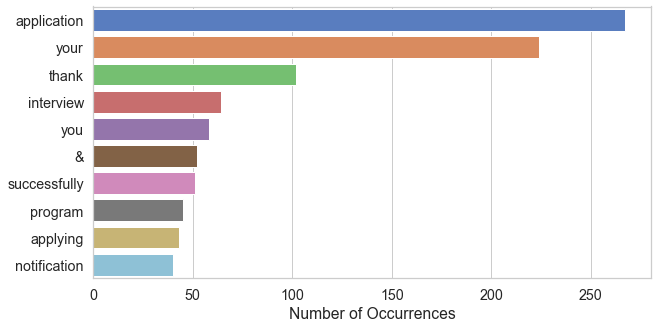

In [53]:
# Visualization
plt.figure(figsize=(10,5))
sns.barplot(counts, words);
plt.ylabel('');
plt.xlabel('Number of Occurrences');

In [54]:
#how many times does interview show up in the subject?

# clean returns only lowercase
interview = ['interview']
counter=0
for item in clean:
      if item in interview:
            counter = counter + 1     
            
print(counter,"times in subject")

64 times in subject


## **Takeaways**
<br>
This project was mainly an attempt to learn more python. I figured using a dataset about myself would make things more interesting.<br><br>
I don't think recruiters know how high the bar is set for college students (without much experience) to get a job. It is extremely competitive. I am extremely fortunate to have recieved the offers I did, and it took a lot of interviewing practice to learn what they look for.

Advice to college students: apply early, build your network and know why you want the job you are applying to
<br><br>
Other Ideas to be explored in this dataset:
* Check which companies didn't respond at all
* How many phone interviews, hirevues, in person interview, multiple rounds etc.
* Which companies requested some sort of assessment first
* Explore the types of jobs (supply chain, IT, data)
* Machine learning; determine which emails are rejection by text of the email body